In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Mean scaling

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


In [3]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))

    return x/mean

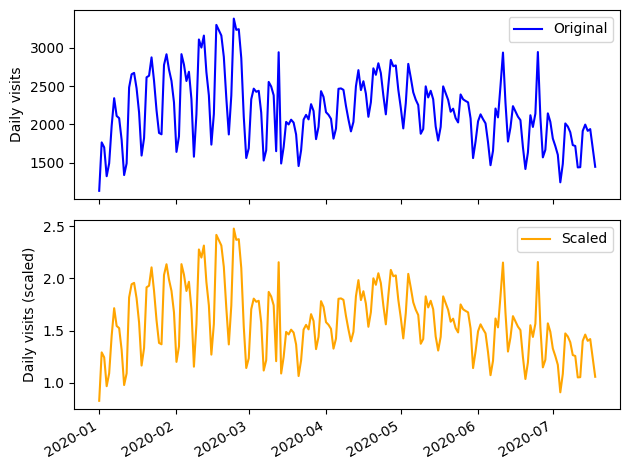

In [4]:
y = df['y'].values
y_scaled = mean_scaling(y)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:200], y[:200], color='blue', label='Original')
ax1.set_ylabel('Daily visits')
ax1.legend()

ax2.plot(df['ds'][:200], y_scaled[:200], color='orange', label='Scaled')
ax2.set_ylabel('Daily visits (scaled)')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Quantization

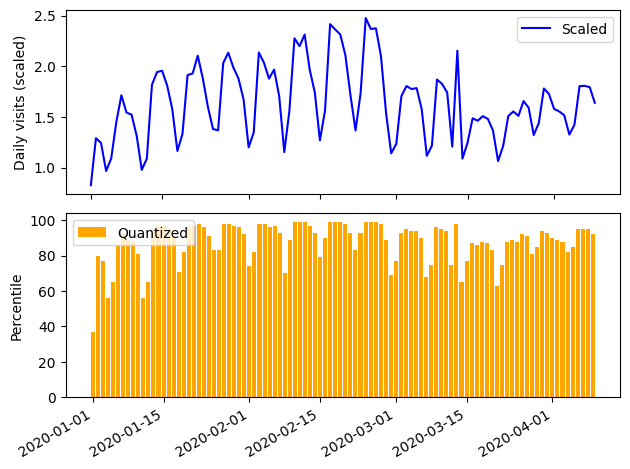

In [5]:
bins = pd.qcut(y_scaled, q=100, labels=False)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:100], y_scaled[:100], color='blue', label='Scaled')
ax1.set_ylabel('Daily visits (scaled)')
ax1.legend()

ax2.bar(df['ds'][:100], bins[:100], color='orange', label='Quantized')
ax2.set_ylabel('Percentile')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting with Chronos

In [6]:
import time
from datasetsforecast.m3 import M3
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate
import torch
from chronos import ChronosPipeline

Y_df, *_ = M3.load(directory='./', group='Monthly')

/home/ubuntu/miniconda3/envs/medium/lib/python3.10/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


In [7]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 12
batch_size = 12


actual = []
chronos_tiny_preds = []

start = time.time()
all_timeseries = [
    torch.tensor(sub_df["y"].values[:-horizon])
    for _, sub_df in Y_df.groupby("unique_id")
]
for i in tqdm(range(0, len(all_timeseries), batch_size)):
    batch_context = all_timeseries[i : i + batch_size]
    forecast = pipeline.predict(batch_context, horizon)
    predictions = np.quantile(forecast.numpy(), 0.5, axis=1)

    chronos_tiny_preds.append(predictions)

chronos_tiny_preds = np.concatenate(chronos_tiny_preds)
chronos_tiny_duration = time.time() - start
print(chronos_tiny_duration)

  0%|          | 0/119 [00:00<?, ?it/s]

19.08080816268921


In [8]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 12
batch_size = 12


actual = []
chronos_large_preds = []

start = time.time()
all_timeseries = [
    torch.tensor(sub_df["y"].values[:-horizon])
    for _, sub_df in Y_df.groupby("unique_id")
]
for i in tqdm(range(0, len(all_timeseries), batch_size)):
    batch_context = all_timeseries[i : i + batch_size]
    forecast = pipeline.predict(batch_context, horizon)
    predictions = np.quantile(forecast.numpy(), 0.5, axis=1)

    chronos_large_preds.append(predictions)

chronos_large_preds = np.concatenate(chronos_large_preds)
chronos_large_duration = time.time() - start
print(chronos_large_duration)

  0%|          | 0/119 [00:00<?, ?it/s]

138.41768598556519


In [9]:
rows = {"unique_id": [], "chronos_tiny_pred": [], "chronos_large_pred": []}
for (name, _), tiny_pred, large_pred in zip(
    Y_df.groupby("unique_id"), chronos_tiny_preds, chronos_large_preds
):
    rows["unique_id"].extend([name] * horizon)
    rows["chronos_tiny_pred"].extend(tiny_pred)
    rows["chronos_large_pred"].extend(large_pred)
chronos_pred_df = pd.DataFrame(rows)

### Testing N-BEATS and MLP

In [10]:
from neuralforecast.models import MLP, NBEATS
from neuralforecast.losses.pytorch import HuberLoss
from neuralforecast.core import NeuralForecast

horizon = 12
val_size = 12
test_size = 12

mlp = MLP(h=horizon, input_size=3*horizon, loss=HuberLoss(), devices=1, accelerator='cpu')

start = time.time()
nf = NeuralForecast(models=[mlp], freq='M')
mlp_forecasts_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None, verbose=True)

mlp_duration = time.time() - start

mlp_forecasts_df.head()

print(mlp_duration)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

23.294083833694458


In [11]:
nbeats = NBEATS(h=horizon, input_size=3*horizon, loss=HuberLoss(), devices=1, accelerator='cpu')

start = time.time()
nf = NeuralForecast(models=[nbeats], freq='M')
nbeats_forecasts_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None, verbose=True)

nbeats_duration = time.time() - start

nbeats_forecasts_df.head()

print(nbeats_duration)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

49.14376521110535


### Evaluation

In [13]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

forecast_df = mlp_forecasts_df
forecast_df["NBEATS"] = nbeats_forecasts_df["NBEATS"]
forecast_df["Chronos-Tiny"] = chronos_pred_df["chronos_tiny_pred"]
forecast_df["Chronos-Large"] = chronos_pred_df["chronos_large_pred"]

evaluation = evaluate(
    forecast_df,
    metrics=[mae, smape],
    models=["MLP", "NBEATS", "Chronos-Tiny", "Chronos-Large"],
    target_col="y",
)

time = pd.DataFrame(
    {
        "metric": ["Time"],
        "MLP": [mlp_duration],
        "NBEATS": [nbeats_duration],
        "Chronos-Tiny": [chronos_tiny_duration],
        "Chronos-Large": [chronos_large_duration],
    }
)
avg_metrics = (
    evaluation.drop(columns="unique_id").groupby("metric").mean().reset_index()
)
avg_metrics = pd.concat([avg_metrics, time]).reset_index(drop=True)

avg_metrics

,metric,MLP,NBEATS,Chronos-Tiny,Chronos-Large
0,mae,566.162569,551.727285,582.312115,563.345977
1,smape,0.064215,0.062675,0.065570,0.063084
2,Time,23.294084,49.143765,19.080808,138.417686
